# Pertemuan 9

- Introduction to **State Of The Art Deep Learning Algorithm** (Computer Vision)
- Face Detection using Pre-trained **MTCNN**
- Keras **Transfer Learning**
    - Transfer Learning using **vanila CNN** for Facerecognition (previous model, part 8)
    - Transfer Learning using **VGG** for Facerecornition
- Keras Transfer Learning with Flask
    - Basic **Flask & SocketIO**
    - **Background Job** using Flask SocketIO
    - **Face Registration** Web App
    - Transfer Learning Keras as Background Job Flask SocketIO

___
## 1. State of The Art Deep Learning Algorithm

![](resource/state-of-the-art.png)

### 1.1 State of The Art Deep Learning Algortihm in Computer Vision
<img src="resource/pwc.png" style="width:750px"></img>
- Object Detection
    - Region CNN (R CNN)
    - Fast R CNN
    - Faster R CNN
    - Yolo
    - Single Shot MultiBox Detector (SSD)
    - Multi-task Cascade CNN (MTCNN)
    - etc.
    - show more : https://paperswithcode.com/task/object-detection
- Image Classification
    - AlexNet
    - ResNet 
    - VGG
    - CapsNet
    - etc.
    - view more : https://paperswithcode.com/task/image-classification
- etc. (https://paperswithcode.com/sota)

___
## 2. Face Detection using MTCNN (Multi Task Cascade Convolution Neural Network)

- *“Multi-Task Cascaded Convolutional Neural Network,”* or **MTCNN** for short, described by Kaipeng Zhang, et al. in the 2016 paper titled *“Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks.”*
- The MTCNN is popular because it achieved then **state-of-the-art** results on a range of benchmark datasets, and because it is capable of also recognizing other **facial features** such as **eyes** and **mouth**, called **landmark detection**.
- The network uses a **cascade structure** with three networks; 
    - first the image is rescaled to a range of different sizes (called an **image pyramid**), 
    - then the first model (Proposal Network or **P-Net**) proposes **candidate facial regions**, 
    - the second model (Refine Network or **R-Net**) **filters the bounding boxes**, and 
    - the third model (Output Network or **O-Net**) proposes **facial landmarks**.
    
<img src="resource/mtcnnmodel1.png" style="width:400px"></img>

- MTCNN Architecture : <br>
<img src="resource/mtcnn-architecture.png" style="width:600px"></img>

### Haar Cascade vs SSD vs HoG vs MTCNN

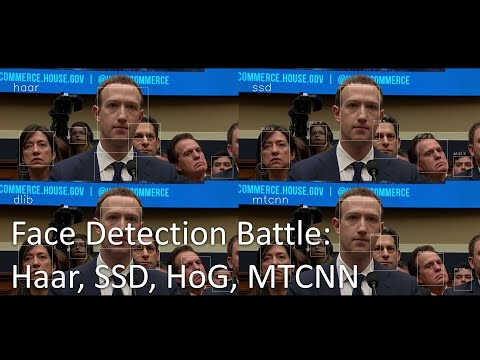

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('GZ2p2hj2H5k', width=853, height=480)

### 2.1 Try MTCNN Facedetection using MTCNN Library

- install **pre-trained** model in library `mtcnn` created by *ipazc/MTCNN*
    - requirement :
        - OpenCV
        - Tensorflow

In [4]:
! pip install mtcnn

- detect face on **image** using `mtcnn`

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

In [3]:
detector_mtcnn = MTCNN()

In [4]:
img = cv2.imread("lena.jpg")
faces = detector_mtcnn.detect_faces(img)
for face in faces:
    print(face)

{'box': [202, 182, 158, 210], 'confidence': 0.997138261795044, 'keypoints': {'left_eye': (267, 265), 'right_eye': (336, 267), 'nose': (316, 317), 'mouth_left': (265, 348), 'mouth_right': (322, 351)}}


confidence : 99.71%


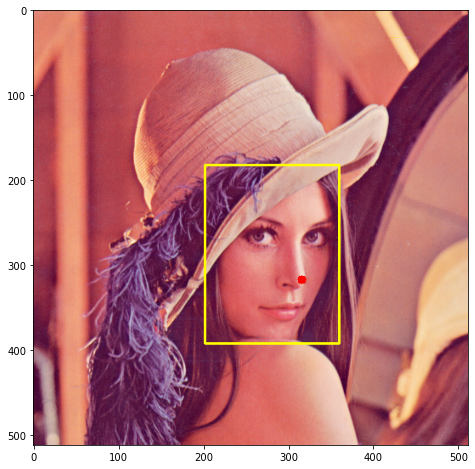

In [12]:
img = cv2.imread("lena.jpg")
faces = detector_mtcnn.detect_faces(img)
for face in faces:
    
    x, y, w, h = face['box']
    cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,255), 2)
    
    n_x, n_y = face['keypoints']['nose']
    cv2.circle(img, (n_x, n_y), 5, (0, 0, 255), -1)
    
    print("confidence : %.2f%%" % (face['confidence']*100))
plt.figure(figsize=(8,8))
plt.imshow(img[:,:,::-1])
plt.show()

> **IMPORTANT NOTICE** : *MTCNN required image in 3D shape (its means we doesn't need to convert data to grayscale before)*.

- detect face on **video frame** using `mtcnn`

In [2]:
from utils import Ped

In [14]:
cap = cv2.VideoCapture(0)
ped = Ped()

while cap.isOpened():
    ret, frame = cap.read()
    
    if ret:
        faces = detector_mtcnn.detect_faces(frame)
        for face in faces:
            x, y, w, h = face['box']
            label_text = "face (%.2f %%)" % (face['confidence']*100)
            frame = ped.draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
            
        cv2.imshow("Face detection MTCNN", frame)
        
        if cv2.waitKey(1) == ord('q'):
            break
    else :
        break
cap.release()
cv2.destroyAllWindows()

## 3. Transfer Learning
<img src="resource/neural-net-learn.gif" style="width:600px"></img>
- Transfer learning consists of **taking features learned** on **one problem**, and leveraging them on **a new, similar problem**. 
- For instance, **features from a model** that has learned to identify **"cat or dog"** may be useful to **kick-start** a model meant to identify **monkey**.
- When to use Transfer Learning :
    - There **isn't enough labeled training data** to train your network from scratch.
    - There **already exists a network** that is **pre-trained** on a similar task, which is usually trained on **massive amounts of data**.
    - When **task 1** and **task 2** have the **same input**. [[1]](https://builtin.com/data-science/transfer-learning)
   <img src="resource/transfer-learning.png" style="width:850px"></img>

- Transfer Learning Workflow :
    - **Take layers** from a previously trained model.
    - **Freeze the layers**, to **avoid destroying** any of the **information** they contain during **future training rounds**.
    - Add some **new**, **trainable layers** on top of the **frozen layers**. 
    - They will **learn** to turn the **old features** into **predictions on a new dataset**.
    - **Train** the **new layers** on **new dataset**. <br>
   <img src="resource/transfer-learning-workflow.png" style="width:700px"></img>

### 3.1 Transfer Learning using Keras for our previous Model

- Load previous saved model (part 8)

In [76]:
from keras.models import load_model
from keras.layers import Dense, Activation

In [77]:
model = load_model("model-cnn-facerecognition.h5")

In [78]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 19, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10368)            

#### 3.1.2 Freeze the model
- Setting `layer.trainable` to `False` moves all the layer's weights from **trainable** to **non-trainable**. 
- This is called **"freezing"** the layer: the state of a **frozen layer won't be updated during training** (either when training with `fit()` or when training with any custom loop that relies on `trainable_weights` to apply gradient updates).

In [79]:
model.layers

In [101]:
help(model.layers[0].trainable)

Help on bool object:

class bool(int)
 |  bool(x) -> bool
 |  
 |  Returns True when the argument x is true, False otherwise.
 |  The builtins True and False are the only two instances of the class bool.
 |  The class bool is a subclass of the class int, and cannot be subclassed.
 |  
 |  Method resolution order:
 |      bool
 |      int
 |      object
 |  
 |  Methods defined here:
 |  
 |  __and__(self, value, /)
 |      Return self&value.
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __or__(self, value, /)
 |      Return self|value.
 |  
 |  __rand__(self, value, /)
 |      Return value&self.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  __ror__(self, value, /)
 |      Return value|self.
 |  
 |  __rxor__(self, value, /)
 |      Return value^self.
 |  
 |  __str__(self, /)
 |      Return str(self).
 |  
 |  __xor__(self, value, /)
 |      Return self^value.
 |  
 |  -----

- keep last 4 layers **trainable**
    >dense_8 (Dense)              (None, 128)  
    dense_9 (Dense)              (None, 64)      
    dense_10 (Dense)             (None, 13)       
    activation_3 (Activation)    (None, 13)  
- Last 4 layers in the model is fully connected layer. 
- This is **classifier** part, after spatial feature extraction in previous sequence of convolutional layers.
- Dimension of utput layers is **13**, this is equal to number of class on previous training run.

In [81]:
for i in range(len(model.layers)):
    if i > 6 :
        model.layers[i].trainable = True # dense layer
    else :
        model.layers[i].trainable = False

In [82]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [105]:
for layer in model.layers:
    print(layer.trainable, '\t',layer.name)

False 	 conv2d_5
False 	 conv2d_6
False 	 max_pooling2d_3
False 	 conv2d_7
False 	 conv2d_8
False 	 max_pooling2d_4
False 	 flatten_2
True 	 dense_8
True 	 dense_9
True 	 dense_22
True 	 activation_4


#### 3.1.3 Modifying Model

- Because we want to **add 1 class** into model (*Angelina_Jolie*), we need to change number of neuron in output layers `Dense` from **13 to 14**. 

In [83]:
model.pop() #remove last Activation layer (Softmax)
model.pop() #remove the last Dense layer - 'Dense' layer with 13 units

In [84]:
model.add(Dense(15))  # equal to number of new classes
model.add(Activation("softmax"))

In [85]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 19, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10368)            

In [86]:
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

#### 3.1.4 Prepare New Dataset

- Load new Dataset

In [87]:
from utils import Preprocessing

In [88]:
prepro = Preprocessing()

In [89]:
names, images = prepro.load_dataset(dataset_folder = "dataset/")


[################### ] (20 samples)	 label : Angelina_Jolie 		
[####################] (50 samples)	 label : Ariel_Sharon 		
[####################] (50 samples)	 label : Colin_Powell 		
[####################] (50 samples)	 label : Donald_Rumsfeld 		
[####################] (50 samples)	 label : George_W_Bush 		
[####################] (50 samples)	 label : Gerhard_Schroeder 		
[####################] (50 samples)	 label : Hugo_Chavez 		
[####################] (50 samples)	 label : Jacques_Chirac 		
[####################] (50 samples)	 label : Jean_Chretien 		
[####################] (50 samples)	 label : John_Ashcroft 		
[####################] (50 samples)	 label : Junichiro_Koizumi 		
[####################] (50 samples)	 label : Serena_Williams 		
[###############     ] (4 samples)	 label : Susilo_Bambang_Yudhoyono 		
[####################] (50 samples)	 label : Tony_Blair 		


In [90]:
names, images = prepro.image_augmentator(images, names)

In [19]:
len(names)

504

In [91]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [92]:
le = LabelEncoder()

le.fit(names)

labels = le.classes_

name_vec = le.transform(names)

categorical_name_vec = to_categorical(name_vec)

- split dataset

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   # input data
                                                    np.array(categorical_name_vec),       # target/output data 
                                                    test_size=0.15, 
                                                    random_state=42)

In [95]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

(12030, 50, 50) (12030, 15) (2124, 50, 50) (2124, 15)


#### 3.1.5 Train a Frozen & Modified Model

In [96]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [97]:
EPOCHS = 3
BATCH_SIZE = 32

history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.15   # 15% of train dataset will be used as validation set
                    )

Train on 10225 samples, validate on 1805 samples
Epoch 1/3
10225/10225 [==============================] - 159s 16ms/step - loss: 1.2408 - accuracy: 0.7731 - val_loss: 0.1729 - val_accuracy: 0.9512
Epoch 2/3
10225/10225 [==============================] - 163s 16ms/step - loss: 0.0931 - accuracy: 0.9744 - val_loss: 0.0990 - val_accuracy: 0.9695
Epoch 3/3
10225/10225 [==============================] - 168s 16ms/step - loss: 0.0261 - accuracy: 0.9933 - val_loss: 0.0824 - val_accuracy: 0.9717


- Evaluate model

In [106]:
from utils import Evaluation

In [107]:
evaluation = Evaluation()

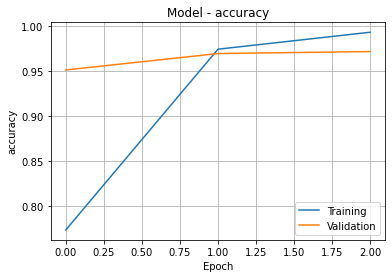

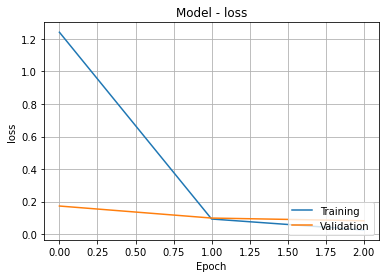

In [108]:
evaluation.plot_history(history)

In [109]:
y_pred = model.predict(x_test)

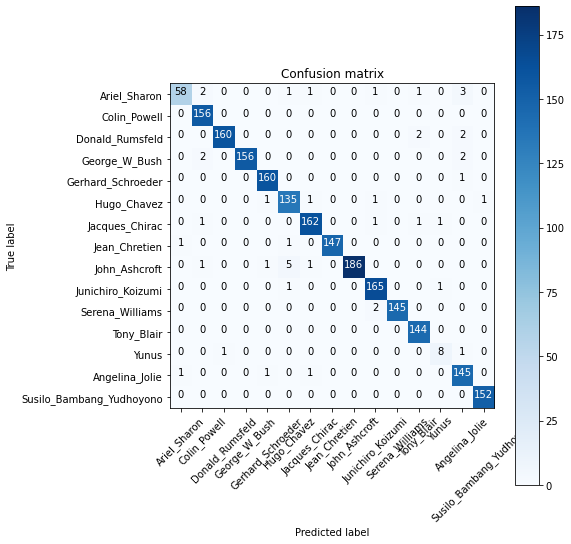

In [110]:
evaluation.plot_confusion_matrix(y_test, y_pred, new_labels)

In [112]:
evaluation.report(y_test, y_pred, new_labels)

                          precision    recall  f1-score   support

            Ariel_Sharon       0.97      0.87      0.91        67
            Colin_Powell       0.96      1.00      0.98       156
         Donald_Rumsfeld       0.99      0.98      0.98       164
           George_W_Bush       1.00      0.97      0.99       160
       Gerhard_Schroeder       0.98      0.99      0.99       161
             Hugo_Chavez       0.94      0.97      0.96       139
          Jacques_Chirac       0.98      0.98      0.98       166
           Jean_Chretien       1.00      0.99      0.99       149
           John_Ashcroft       1.00      0.96      0.98       194
       Junichiro_Koizumi       0.97      0.99      0.98       167
         Serena_Williams       1.00      0.99      0.99       147
              Tony_Blair       0.97      1.00      0.99       144
                   Yunus       0.80      0.80      0.80        10
          Angelina_Jolie       0.94      0.98      0.96       148
Susilo_Ba

- Save model

In [34]:
model.save("new_model-cnn-facerecognition.h5")

#### 3.1.6 Optimize Model For Inference

In [36]:
from optimizer import ModelOptimizer

In [37]:
opt = ModelOptimizer()

In [43]:
opt.h5_to_savedModel(model_name='model-cnn-facerecognition.h5', savedModel_folder="tf_model")

INFO:tensorflow:Assets written to: tf_model\assets


In [44]:
opt.optimize(savedModel_folder="tf_model", target_name='frozen_graph.pb')

#### 3.1.7 Test Model after Transfer Learning

In [45]:
import cv2
from utils import Ped

In [46]:
new_labels = ['Ariel_Sharon',
              'Colin_Powell',
              'Donald_Rumsfeld',
              'George_W_Bush',
              'Gerhard_Schroeder',
              'Hugo_Chavez',
              'Jacques_Chirac',
              'Jean_Chretien',
              'John_Ashcroft',
              'Junichiro_Koizumi',
              'Serena_Williams',
              'Tony_Blair',
              'Yunus',
              'Angelina_Jolie',
              'Susilo_Bambang_Yudhoyono'] # new class in labels list

In [47]:
# --------- load MTCNN model -------------
detector_mtcnn = MTCNN()

# --------- load tensorflow optimized model ---------
facerecognition_model = "frozen_graph.pb"
net = cv2.dnn.readNet(facerecognition_model)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
layerOutput = net.getUnconnectedOutLayersNames()

cap = cv2.VideoCapture(0)

ped = Ped()

while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        faces = detector_mtcnn.detect_faces(frame)
        for face in faces:
            x, y, w, h = face['box']
            
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            
            blob = cv2.dnn.blobFromImage(face_img, 1.0, (50, 50), (0, 0, 0), swapRB=True, crop=False)
            net.setInput(blob)
            output = net.forward(layerOutput)
            idx = output[0].argmax(axis=1)[0]
            confidence = output[0].max(axis=1)[0]*100
            
            if confidence > 60:
                label_text = "%s (%.2f %%)" % (new_labels[idx], confidence)
            else :
                label_text = "N/A"
            frame = ped.draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
       
        cv2.imshow('Face Recognition', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

### 3.2 Transfer Learning using VGG16 pre-trained model

 - VGG 16 Architecture :<br>
  <img src="resource/vgg16.png" style="width:700px"></img>

In [48]:
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Input

- List pre-trained model provide by Keras

In [2]:
dir(keras.applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'absolute_import',
 'backend',
 'densenet',
 'division',
 'inception_resnet_v2',
 'inception_v3',
 'keras_applications',
 'keras_modules_injection',
 'layers',
 'mobilenet',
 'mobilenet_v2',
 'models',
 'nasnet',
 'print_function',
 'resnet',
 'resnet50',
 'resnet_v2',
 'utils',
 'vgg16',
 'vgg19',
 'xception']

- Using Pretrained Model VGG16 for Facerecognition
>```
keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
```

#### 3.2.1 Load & Modify Model

In [49]:
model_vgg16 = keras.applications.VGG16(
                                      weights="imagenet",
                                      input_shape=(50, 50, 3),
                                      include_top=False
                                     )

model_vgg16.trainable = False

In [62]:
inputs = Input(shape=(50, 50, 3))

x = model_vgg16(inputs)

x = Flatten()(x)
x = Dense(128)(x)
x = Dense(64)(x)
x = Dense(14)(x)
outputs = Activation("softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_21 (Dense)             (None, 14)                910       
_________________________________________________________________
activation_3 (Activation)    (None, 14)                0   

#### 3.2.2 Prepare Dataset
- Extract **lfw deep funneled images** 

In [63]:
from utils import Preprocessing

In [64]:
prepro = Preprocessing()

In [65]:
names, images = prepro.load_dataset(dataset_folder = "dataset/",  size=(50,50), is_gray=False, max_sample=50)


[################### ] (20 samples)	 label : Angelina_Jolie 		
[####################] (50 samples)	 label : Ariel_Sharon 		
[####################] (50 samples)	 label : Colin_Powell 		
[####################] (50 samples)	 label : Donald_Rumsfeld 		
[####################] (50 samples)	 label : George_W_Bush 		
[####################] (50 samples)	 label : Gerhard_Schroeder 		
[####################] (50 samples)	 label : Hugo_Chavez 		
[####################] (50 samples)	 label : Jacques_Chirac 		
[####################] (50 samples)	 label : Jean_Chretien 		
[####################] (50 samples)	 label : John_Ashcroft 		
[####################] (50 samples)	 label : Junichiro_Koizumi 		
[####################] (50 samples)	 label : Serena_Williams 		
[####################] (50 samples)	 label : Tony_Blair 		


In [66]:
#names, images = prepro.image_augmentator(images, names)

In [67]:
len(names)

670

In [68]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [69]:
le = LabelEncoder()

le.fit(names)

labels = le.classes_

name_vec = le.transform(names)

categorical_name_vec = to_categorical(name_vec)

In [70]:
labels

array(['Angelina_Jolie', 'Ariel_Sharon', 'Colin_Powell',
       'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder',
       'Hugo_Chavez', 'Jacques_Chirac', 'Jean_Chretien', 'John_Ashcroft',
       'Junichiro_Koizumi', 'Serena_Williams', 'Tony_Blair', 'Yunus'],
      dtype='<U17')

- split dataset

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   # input data
                                                    np.array(categorical_name_vec),       # target/output data 
                                                    test_size=0.15, 
                                                    random_state=42)

In [73]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

(569, 50, 50, 3) (569, 14) (101, 50, 50, 3) (101, 14)


#### 3.1.5 Train a Frozen & Modified Model

In [75]:
EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.15   # 15% of train dataset will be used as validation set
                    )

Train on 483 samples, validate on 86 samples
Epoch 1/10
483/483 [==============================] - 30s 61ms/step - loss: 3.3159 - accuracy: 0.5404 - val_loss: 7.8002 - val_accuracy: 0.3256
Epoch 2/10
483/483 [==============================] - 28s 59ms/step - loss: 2.7077 - accuracy: 0.6170 - val_loss: 4.7723 - val_accuracy: 0.4302
Epoch 3/10
483/483 [==============================] - 28s 57ms/step - loss: 1.8680 - accuracy: 0.6729 - val_loss: 4.4107 - val_accuracy: 0.4651
Epoch 4/10
483/483 [==============================] - 27s 55ms/step - loss: 1.4472 - accuracy: 0.6998 - val_loss: 4.1182 - val_accuracy: 0.4651
Epoch 5/10
483/483 [==============================] - 25s 52ms/step - loss: 1.1600 - accuracy: 0.7308 - val_loss: 4.0755 - val_accuracy: 0.4767
Epoch 6/10
483/483 [==============================] - 28s 58ms/step - loss: 1.4690 - accuracy: 0.7288 - val_loss: 4.7438 - val_accuracy: 0.4070
Epoch 7/10
483/483 [==============================] - 29s 60ms/step - loss: 1.3198 - accura